In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import time
import math
import datetime

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Activation
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
from collections import deque

In [ ]:
df = pd.read_csv('bitcoindata.csv')

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [ ]:
df['Open'] = pd.to_numeric(df['Open'].str.replace(',', ''), errors='coerce')
df['High'] = pd.to_numeric(df['High'].str.replace(',', ''), errors='coerce')
df['Low'] = pd.to_numeric(df['Low'].str.replace(',', ''), errors='coerce')
df['Close'] = pd.to_numeric(df['Close'].str.replace(',', ''), errors='coerce')

Text(0.5, 1.0, 'High v/s Low')

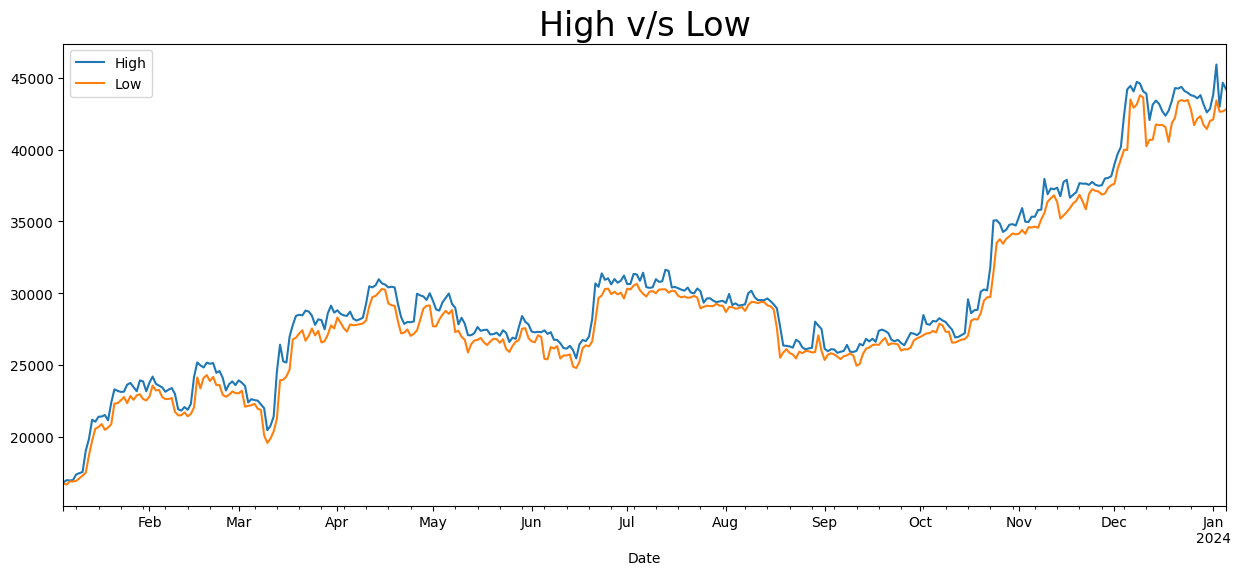

In [ ]:
ax = df[['High','Low']].plot(figsize=(15,6))
ax.set_title("High v/s Low",fontsize=24)

Text(0.5, 1.0, 'Opening v/s Closing')

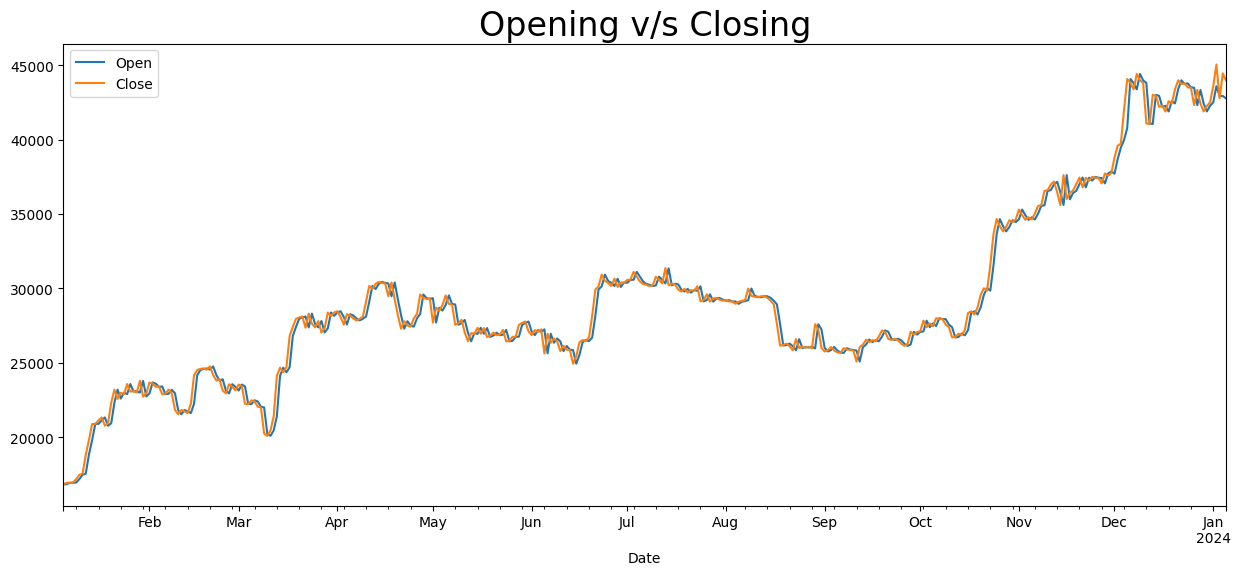

In [ ]:
ax = df[['Open','Close']].plot(figsize=(15,6))
ax.set_title("Opening v/s Closing",fontsize=24)

Text(0.5, 1.0, 'Market Performance 2023 October onwards')

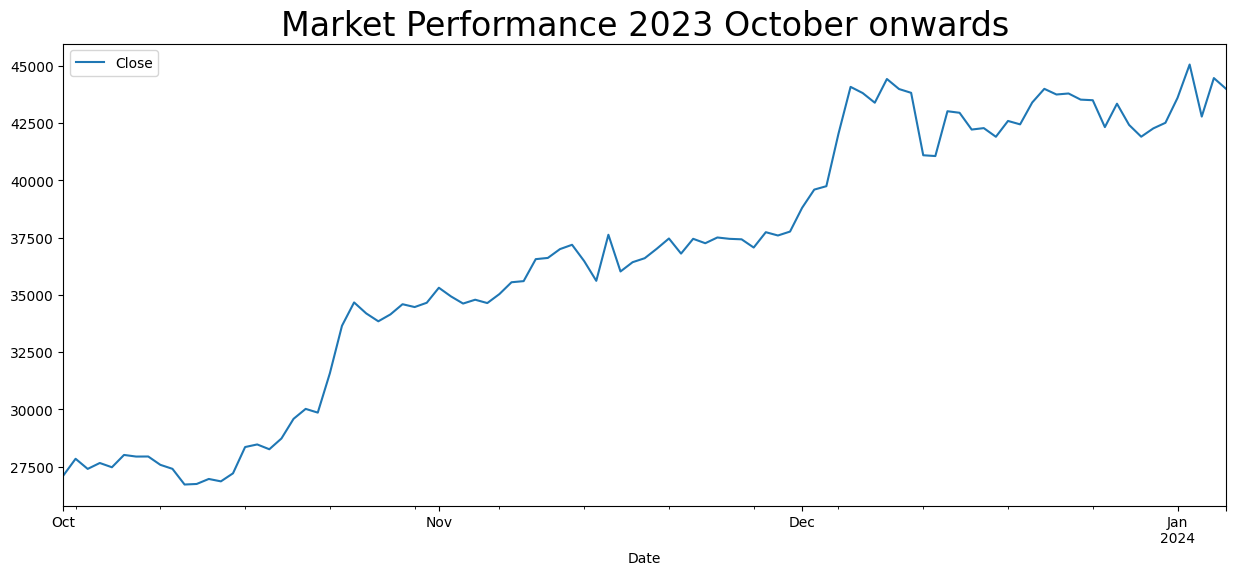

In [ ]:
ax = df[['Close']]['2023-10':].plot(figsize=(15,6))
ax.set_title('Market Performance 2023 October onwards',fontsize=24)

In [ ]:
df.isnull().sum()

Open     0
High     0
Low      0
Close    0
dtype: int64

In [ ]:
X=list(df["Close"])
X=[float(x) for x in X]

In [ ]:
validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]

In [ ]:
from keras.models import load_model

In [ ]:
class Agent:
    def __init__(self, state_size, for_eval = False, model_name=""):
        self.state_size = state_size
        self.action_size = 3
        self.memory = deque(maxlen=1000)
        self.model_name = model_name
        self.for_eval = for_eval
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

        self.model = load_model(model_name) if for_eval else self._model()

    def _model(self):
        model = Sequential()
        #Input Layer
        model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
        #Hidden Layers
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        #Output Layer
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(lr=0.001))
        return model

    def act(self,state):

        if not self.for_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)

        predicted_outputs = self.model.predict(state)
        return np.argmax(predicted_outputs[0])

    def learn_experience(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])

        for state, action, reward, next_state, done in mini_batch:
            target = reward

            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

            target_f = self.model.predict(state)
            # Update the output Q table for the given action in the table
            target_f[0][action] = target
            #train and fit the model where state is X and target_f is Y, where the target is updated.
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *=self.epsilon_decay



In [ ]:
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

In [ ]:
def sigmoid(x):
    if x >= 0:
        return 1 / (1 + math.exp(-x))
    else:
        return math.exp(x) / (1 + math.exp(x))

In [ ]:
def getState(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1]
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    return np.array([res])

In [ ]:
def plot_behavior(data_input, states_buy, states_sell, profit):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='r', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='m', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='k', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    plt.show()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 40ms/step
--------------------------------
Total Profit: -$107490.00
--------------------------------


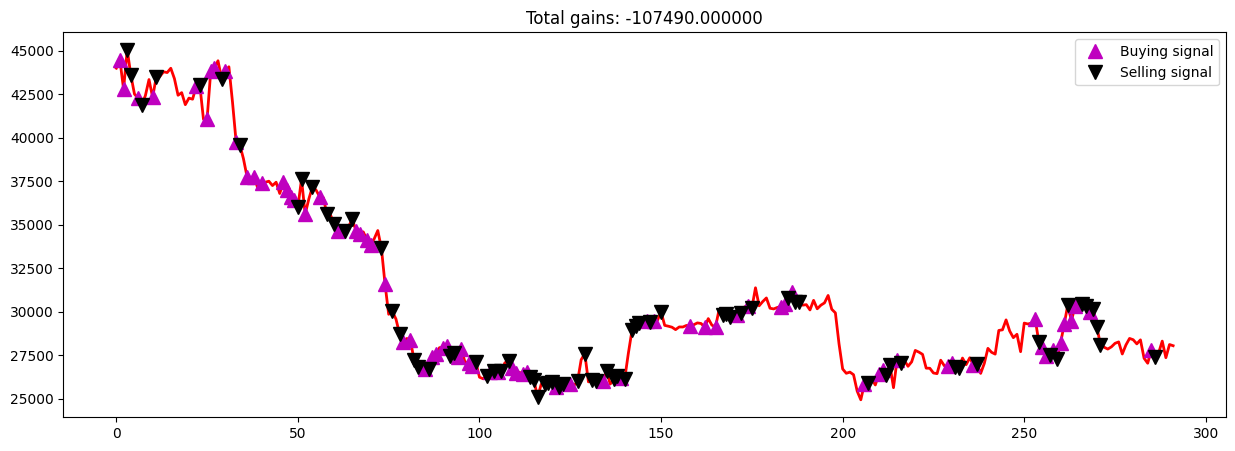

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 32ms/step
--------------------------------
Total Profit: -$10480.00
--------------------------------


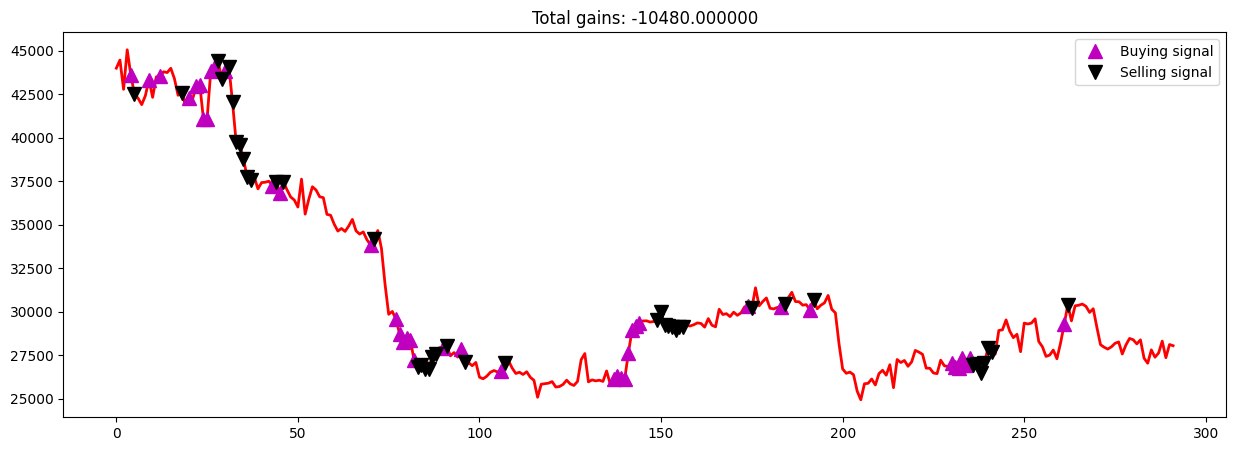

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - ETA: 0s

In [ ]:
from IPython.core.debugger import set_trace
window_size = 1
agent = Agent(window_size)
data = X_train
l = len(data) - 1
batch_size = 32
episode_count = 10

for e in range(episode_count + 1):
    print("Running episode " + str(e) + "/" + str(episode_count))
    state = getState(data, 0, window_size + 1)

    total_profit = 0
    agent.inventory = []
    states_sell = []
    states_buy = []
    for t in range(l):
        action = agent.act(state)
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0

        if action == 1: # buy
            agent.inventory.append(data[t])
            states_buy.append(t)
            #print("Buy: " + formatPrice(data[t]))

        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = agent.inventory.pop(0)
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            states_sell.append(t)
            #print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))

        done = True if t == l - 1 else False
        #appends the details of the state action etc in the memory, which is used further by the exeReply function
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            print("--------------------------------")
            print("Total Profit: " + formatPrice(total_profit))
            print("--------------------------------")
            #set_trace()
            #pd.DataFrame(np.array(agent.memory)).to_csv("Agent"+str(e)+".csv")
            #Chart to show how the model performs with the stock goin up and down for each
            plot_behavior(data,states_buy, states_sell, total_profit)
        if len(agent.memory) > batch_size:
            agent.learn_experience(batch_size)


    if e % 2 == 0:
        agent.model.save("model_ep" + str(e))